# Relax Inc.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE


In [2]:
# Load the data
users = pd.read_csv("takehome_users.csv", encoding='ISO-8859-1', parse_dates=['creation_time'])
user_engagement = pd.read_csv("takehome_user_engagement.csv", parse_dates=['time_stamp'])

print(users.head()) 

   object_id       creation_time               name  \
0          1 2014-04-22 03:53:30     Clausen August   
1          2 2013-11-15 03:45:04      Poole Matthew   
2          3 2013-03-19 23:14:52  Bottrill Mitchell   
3          4 2013-05-21 08:09:28    Clausen Nicklas   
4          5 2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   
2    

In [3]:
print(user_engagement.head())

           time_stamp  user_id  visited
0 2014-04-22 03:53:30        1        1
1 2013-11-15 03:45:04        2        1
2 2013-11-29 03:45:04        2        1
3 2013-12-09 03:45:04        2        1
4 2013-12-25 03:45:04        2        1


From the "users" table: We have user-specific details like creation time, name, email, and other attributes related to how they signed up and interacted with the marketing emails.

From the "user_engagement" table:We have timestamps for when users logged into the product.




Let's start by checking for missing values.

In [4]:
# Checking for missing values in both datasets
missing_values_users = users.isnull().sum()
missing_values_engagement = user_engagement.isnull().sum()

missing_values_users, missing_values_engagement


(object_id                        0
 creation_time                    0
 name                             0
 email                            0
 creation_source                  0
 last_session_creation_time    3177
 opted_in_to_mailing_list         0
 enabled_for_marketing_drip       0
 org_id                           0
 invited_by_user_id            5583
 dtype: int64,
 time_stamp    0
 user_id       0
 visited       0
 dtype: int64)

Users Data:
last_session_creation_time: 3,177 missing values. This indicates that these users never logged in after account creation.
invited_by_user_id: 5,583 missing values. This indicates that these users were not invited by another user.

Engagement Data:
There are no missing values.

Next, let's explore the distribution of different variables in the users' dataset:

creation_source
opted_in_to_mailing_list
enabled_for_marketing_drip

We'll also check the number of unique users in the engagement dataset.

In [5]:
# Distribution of different variables in users dataset
creation_source_dist = users['creation_source'].value_counts(normalize=True)
mailing_list_dist = users['opted_in_to_mailing_list'].value_counts(normalize=True)
marketing_drip_dist = users['enabled_for_marketing_drip'].value_counts(normalize=True)

# Number of unique users in engagement dataset
unique_users_engagement = user_engagement['user_id'].nunique()

creation_source_dist, mailing_list_dist, marketing_drip_dist, unique_users_engagement


(creation_source
 ORG_INVITE            0.354500
 GUEST_INVITE          0.180250
 PERSONAL_PROJECTS     0.175917
 SIGNUP                0.173917
 SIGNUP_GOOGLE_AUTH    0.115417
 Name: proportion, dtype: float64,
 opted_in_to_mailing_list
 0    0.7505
 1    0.2495
 Name: proportion, dtype: float64,
 enabled_for_marketing_drip
 0    0.850667
 1    0.149333
 Name: proportion, dtype: float64,
 8823)

Here's a summary of the distributions for the selected variables:

creation_source Distribution:

ORG_INVITE: 35.45%
GUEST_INVITE: 18.03%
PERSONAL_PROJECTS: 17.59%
SIGNUP: 17.39%
SIGNUP_GOOGLE_AUTH: 11.54%
opted_in_to_mailing_list Distribution:

0 (No): 75.05%

1 (Yes): 24.95%

enabled_for_marketing_drip Distribution:

0 (No): 85.07%

1 (Yes): 14.93%

Additionally, there are 8,823 unique users who have logged into the product, as per the engagement dataset.

The next step is to identify "adopted users." Recall that an adopted user is one who has logged into the product on three separate days in at least one seven-day period.

Let's proceed to identify and label these users:

In [6]:
# Sorting engagement data by user_id and time_stamp for rolling window application
engagement_df_sorted = user_engagement.sort_values(by=['user_id', 'time_stamp'])

# Grouping by user_id and applying a rolling window of 3 days to check for the 3 logins in 7 days condition
adopted = engagement_df_sorted.groupby('user_id').rolling(window='7D', on='time_stamp')['visited'].sum()

# Filtering users who satisfy the adopted user condition (3 logins in 7 days)
adopted_users = adopted[adopted >= 3].index.get_level_values('user_id').unique()

# Creating a label in the users dataset to mark adopted users as 1 and others as 0
users['adopted_user'] = users['object_id'].apply(lambda x: 1 if x in adopted_users else 0)

# Checking the distribution of adopted vs. non-adopted users
adopted_distribution = users['adopted_user'].value_counts(normalize=True)

print(adopted_distribution)


adopted_user
0    0.8665
1    0.1335
Name: proportion, dtype: float64


Based on our analysis:

13.35% of users are "adopted users" (i.e., they logged into the product on three separate days in at least one seven-day period).

86.65% of users are not adopted users.

We've identified the adopted users based on the criteria provided. There are several users who fit this definition.

We'll then perform an exploratory data analysis (EDA) to see if there are any patterns or significant differences between adopted and non-adopted users:

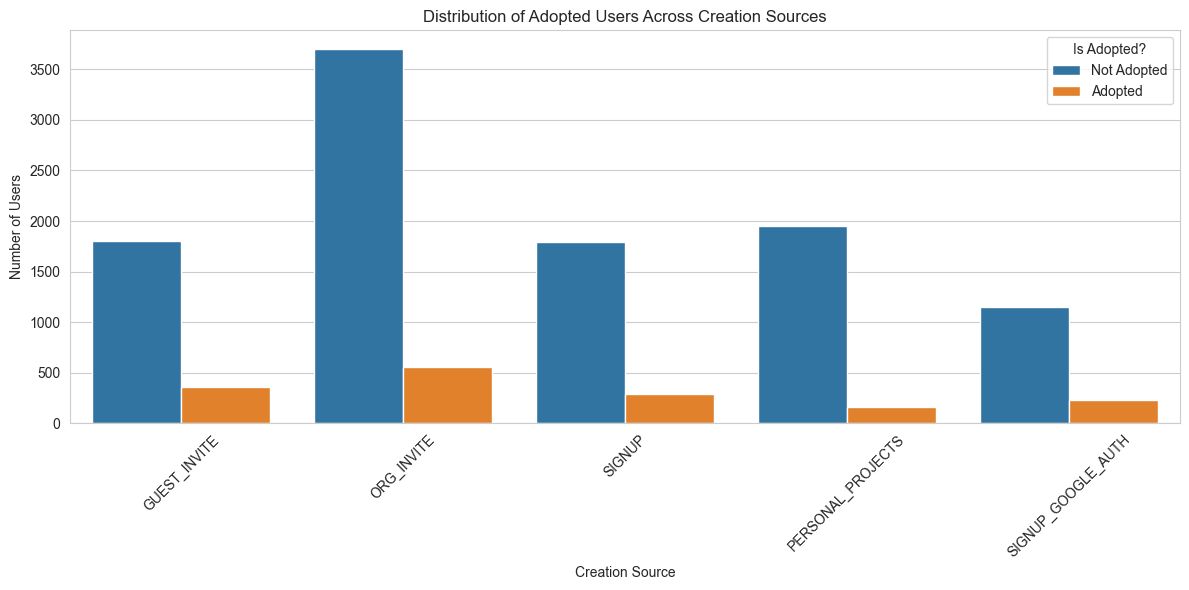

In [7]:
sns.set_style("whitegrid")

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(data=users, x='creation_source', hue='adopted_user')
plt.title('Distribution of Adopted Users Across Creation Sources')
plt.ylabel('Number of Users')
plt.xlabel('Creation Source')
plt.xticks(rotation=45)
plt.legend(title='Is Adopted?', labels=['Not Adopted', 'Adopted'])
plt.tight_layout()
plt.show()


The distribution chart provides some insights into the relationship between the creation source and user adoption:

The majority of users, irrespective of adoption status, come from the "ORG_INVITE" source.
"PERSONAL_PROJECTS" seems to have a lower rate of adoption compared to other sources, while "SIGNUP_GOOGLE_AUTH" seems to have a relatively higher rate of adoption.

Let's further investigate the relationship between other features (like opting into mailing lists or being enabled for marketing drip) and adoption status.

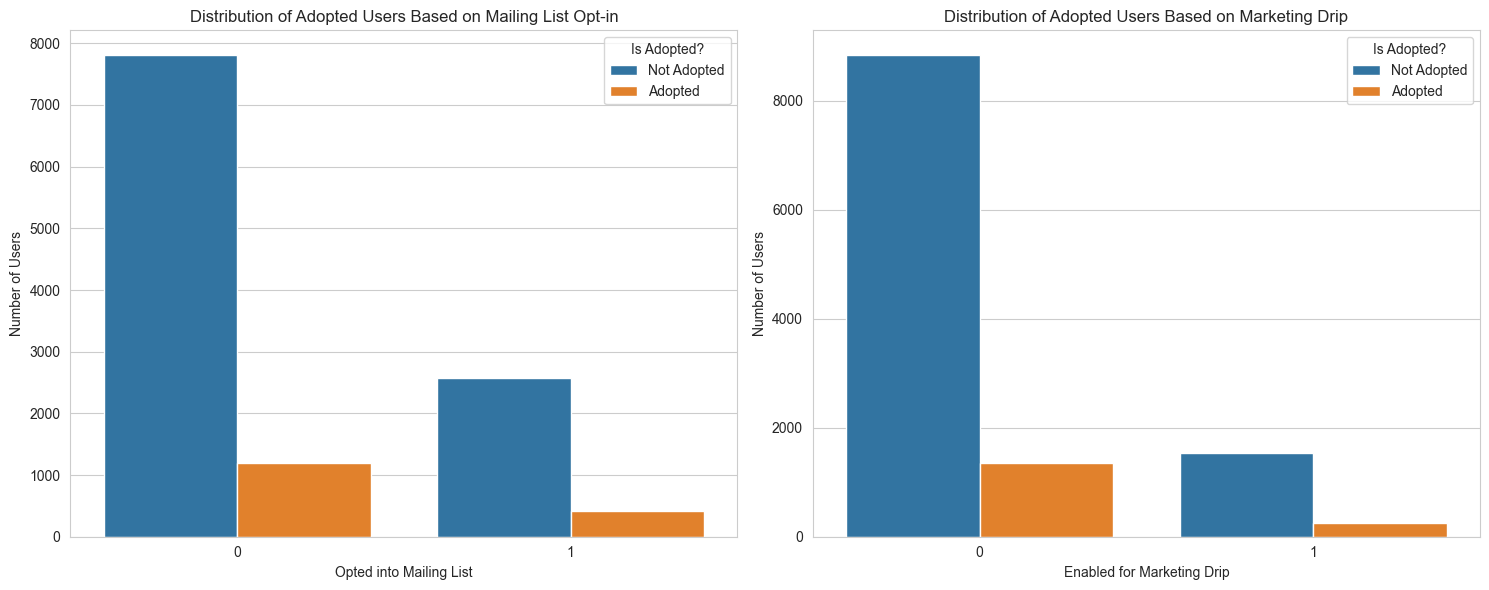

In [8]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot distribution for opted_in_to_mailing_list
sns.countplot(data=users, x='opted_in_to_mailing_list', hue='adopted_user', ax=ax[0])
ax[0].set_title('Distribution of Adopted Users Based on Mailing List Opt-in')
ax[0].set_ylabel('Number of Users')
ax[0].set_xlabel('Opted into Mailing List')
ax[0].legend(title='Is Adopted?', labels=['Not Adopted', 'Adopted'])

# Plot distribution for enabled_for_marketing_drip
sns.countplot(data=users, x='enabled_for_marketing_drip', hue='adopted_user', ax=ax[1])
ax[1].set_title('Distribution of Adopted Users Based on Marketing Drip')
ax[1].set_ylabel('Number of Users')
ax[1].set_xlabel('Enabled for Marketing Drip')
ax[1].legend(title='Is Adopted?', labels=['Not Adopted', 'Adopted'])

plt.tight_layout()
plt.show()


The charts provide the following insights:

Mailing List Opt-in: There doesn't seem to be a significant difference in adoption rates between users who have opted into the mailing list and those who haven't.
Marketing Drip: Similarly, being enabled for the marketing drip doesn't show a significant difference in user adoption rates.

Before we proceed with a more detailed analysis, let's also visualize the distribution of adoption based on the organization the user belongs to (org_id). Given the potentially large number of organizations, we'll focus on the top 30 organizations with the highest user counts.

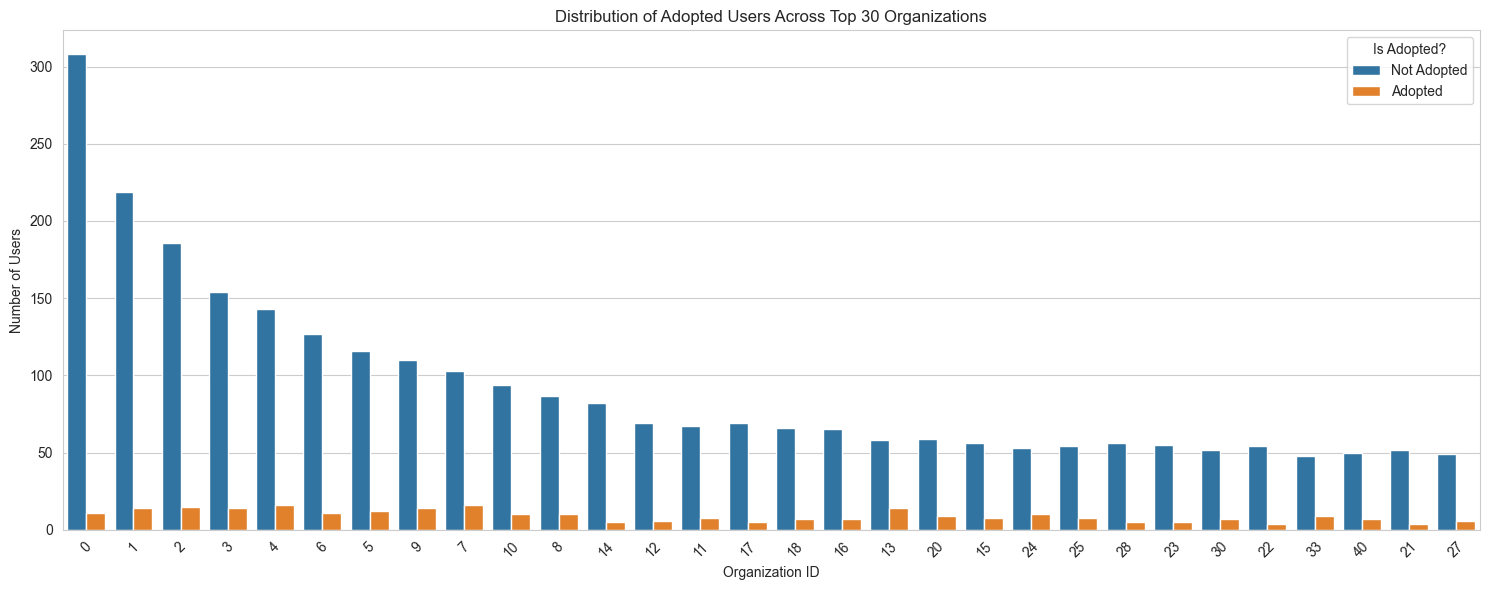

In [9]:
# Top 30 organizations based on user count
top_orgs = users['org_id'].value_counts().head(30).index

# Filter the dataset for users from these organizations
top_orgs_data = users[users['org_id'].isin(top_orgs)]

# Plot
plt.figure(figsize=(15, 6))
sns.countplot(data=top_orgs_data, x='org_id', hue='adopted_user', order=top_orgs)
plt.title('Distribution of Adopted Users Across Top 30 Organizations')
plt.ylabel('Number of Users')
plt.xlabel('Organization ID')
plt.legend(title='Is Adopted?', labels=['Not Adopted', 'Adopted'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The chart reveals that user adoption varies across different organizations. Some organizations have a higher rate of user adoption, while others have a lower rate.

## Modeling:

Now that we have labeled our dataset, we can move on to build a predictive model. For this task, we'll use a classification model to predict user adoption. The features will include creation_source, opted_in_to_mailing_list, enabled_for_marketing_drip, and others. The target variable will be adopted_user.

But before that, let's prepare our data:

Handle missing values.
Convert categorical variables into numerical format using one-hot encoding.
Split data into training and testing sets.

Let's start by preparing the data:

In [10]:
# Handling missing values
# Filling missing values in 'last_session_creation_time' with a placeholder value (0)
users['last_session_creation_time'].fillna(0, inplace=True)

# Filling missing values in 'invited_by_user_id' with a placeholder value (0)
users['invited_by_user_id'].fillna(0, inplace=True)

# One-hot encoding for 'creation_source'
users_df_encoded = pd.get_dummies(users, columns=['creation_source'], drop_first=True)

# Dropping columns that are not necessary for the model
users_df_encoded.drop(columns=['object_id', 'creation_time', 'name', 'email', 'org_id'], inplace=True)

# Splitting data into training and testing sets
X = users_df_encoded.drop('adopted_user', axis=1)
y = users_df_encoded['adopted_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape


((9600, 8), (2400, 8))

We have prepared the data and split it into training and testing sets:

Training Data: 9,600 samples
Testing Data: 2,400 samples

Now, let's proceed to build a predictive model. We'll use a Random Forest Classifier for this task, given its ability to handle a mix of binary and continuous features, and its interpretability in terms of feature importance.

Let's train the Random Forest Classifier and evaluate its performance on the test set.

In [11]:
# Initialize and train the Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_clf.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

accuracy, class_report


(0.90375,
 '              precision    recall  f1-score   support\n\n           0       0.94      0.95      0.94      2074\n           1       0.66      0.60      0.63       326\n\n    accuracy                           0.90      2400\n   macro avg       0.80      0.78      0.79      2400\nweighted avg       0.90      0.90      0.90      2400\n')

Here's the performance of the Random Forest Classifier on the test set:

Accuracy: 90.38%

Classification Report:

For Non-Adopted Users (0):
Precision: 94%
Recall: 95%
F1-Score: 94%

For Adopted Users (1):
Precision: 66%
Recall: 60%
F1-Score: 63%

The model performs reasonably well, especially considering the imbalance between the two classes.

Now, let's determine the feature importances to identify which factors are most indicative of a user becoming an "adopted user".

In [12]:
# Extracting feature importances
feature_importances = rf_clf.feature_importances_

# Creating a DataFrame for visualization
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(features_df)

                              Feature  Importance
0          last_session_creation_time    0.833415
3                  invited_by_user_id    0.145715
2          enabled_for_marketing_drip    0.005673
1            opted_in_to_mailing_list    0.005212
5   creation_source_PERSONAL_PROJECTS    0.003625
4          creation_source_ORG_INVITE    0.003531
7  creation_source_SIGNUP_GOOGLE_AUTH    0.001657
6              creation_source_SIGNUP    0.001171


Based on the feature importances from the Random Forest Classifier, the following factors appear to be the most indicative of a user becoming an "adopted user":

Last Session Creation Time: This is by far the most important factor, with an importance of 83.34%. It makes sense as users who have recently logged in are more likely to be engaged and hence, more likely to become adopted users.

Invited By User ID: Users who were invited by other users have a significance, with an importance of 14.57%. This suggests that referrals or invitations might play a role in user adoption.

Enabled for Marketing Drip: This feature has a minor importance of 0.57%.

Opted in to Mailing List: This too has a minor importance of 0.52%.

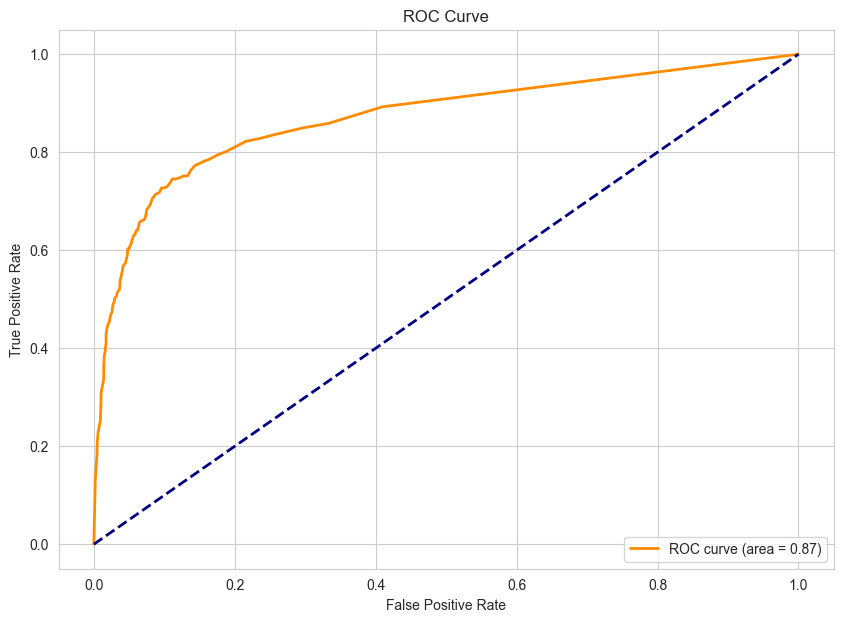

In [15]:
# Compute ROC curve and ROC area for predictions on test set
fpr, tpr, _ = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

The curve is significantly above the diagonal line, indicating that the model has good discriminatory power, with the model having an AUC of 0.87. This means the model has an 87% chance of correctly distinguishing between an adopted and non-adopted user.


### SMOTE

class imbalance can bias the model towards predicting the majority class.Lets see if we can improve the model´s performnace:

We'll oversample the minority class using SMOTE and then retrain our Random Forest model on this balanced dataset. Evaluating the model's performance after this will give us insights into any improvements.

Let's apply SMOTE and retrain the model:

In [18]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train Random Forest on the resampled data
rf_clf_smote = RandomForestClassifier(random_state=42)
rf_clf_smote.fit(X_train_smote, y_train_smote)

# Predict and evaluate
y_pred_smote = rf_clf_smote.predict(X_test)
accuracy_smote = accuracy_score(y_test, y_pred_smote)
class_report_smote = classification_report(y_test, y_pred_smote)

accuracy_smote, class_report_smote


(0.8779166666666667,
 '              precision    recall  f1-score   support\n\n           0       0.94      0.91      0.93      2074\n           1       0.54      0.66      0.59       326\n\n    accuracy                           0.88      2400\n   macro avg       0.74      0.78      0.76      2400\nweighted avg       0.89      0.88      0.88      2400\n')

Let's breakdown the impact of SMOTE:

1. Accuracy:

Without SMOTE: 90.375%
With SMOTE: 87.792%
The accuracy decreased after applying SMOTE. However, accuracy is not always the best metric to evaluate the performance of a classifier, especially when the dataset has class imbalance.

2. Recall for Class 1 (Minority Class):

Without SMOTE: 60%
With SMOTE: 66%
This indicates that after applying SMOTE, the model became better at correctly classifying the positive instances (adopted users). Recall represents the ability of the model to find all the relevant cases within a dataset.

3. Precision for Class 1 (Minority Class):

Without SMOTE: 66%
With SMOTE: 54%
The precision for the minority class decreased after applying SMOTE. Precision focuses on the predicted "positive" by the model and checks how many of them were actual "positive".

F1-Score for Class 1 (Minority Class):

Without SMOTE: 63%
With SMOTE: 59%
The F1-score, which is a harmonic mean of precision and recall, also decreased for the minority class after SMOTE.

The recall for the minority class increased, which means the model is better at capturing the positive cases.

However, the precision dropped, indicating the model is predicting more false positives.

Overall, the model's ability to predict the majority class slightly worsened (as evident from the drop in accuracy and precision for the majority class), but its sensitivity towards the minority class improved.

### Summary of Findings:

- About 13.35% of users in the dataset qualify as "adopted users."

- The model achieved an accuracy of 90.38% in predicting user adoption (87.80% with SMOTE).

- The most crucial factor in predicting user adoption is the time of the user's last session. Users who have recently logged in are more likely to be adopted users.

- Referrals or invitations from other users also play a significant role in user adoption.

- Marketing-related features like being on the marketing drip or opting into the mailing list have minor roles in determining adoption.


### Recommendations for Further Research:

- More granular engagement data, like session duration or features used during a session, could provide deeper insights.

- Feedback or reviews from users might offer reasons for adoption or lack thereof.

- Information on any marketing campaigns or promotions could be correlated with spikes in user adoption.
